In [12]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import itertools

from os import path

from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.utils.class_weight import compute_class_weight

from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

from torch.utils.data import DataLoader, TensorDataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW

from collections import Counter

## Import dataset

In [22]:
data = pd.read_csv('Dataset/UNSW_NB15_training-set.csv')

print("Kolom UNSW:", data.columns)

Kolom UNSW: Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')


# Data Preparation

## EDA

In [23]:
data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

In [28]:
data.isna().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

## Data Visualization

Class distribution: ransomware vs normal:
label
1    119341
0     56000
Name: count, dtype: int64


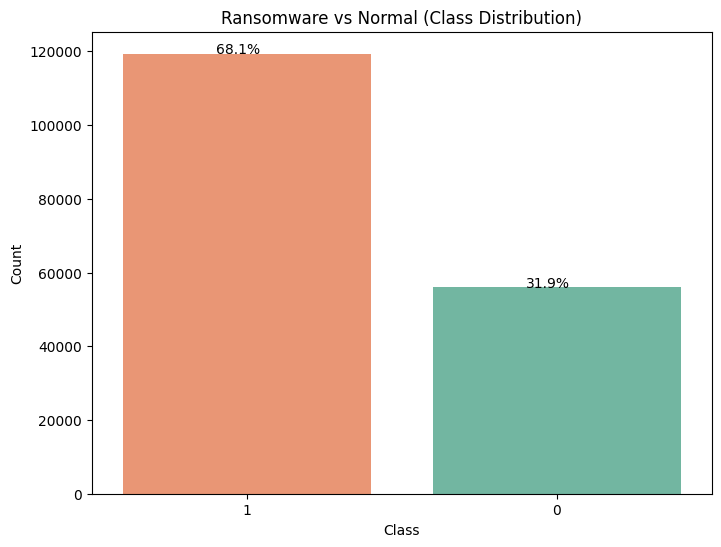

In [30]:
if 'label' in data.columns:
    print("Class distribution: ransomware vs normal:")
    class_counts = data['label'].value_counts()
    print(class_counts)

    # Plot the distribution of classes
    plt.figure(figsize=(8, 6))

    ax = sns.countplot(data=data, x='label', hue='label', order=class_counts.index, palette='Set2', legend=False)
    plt.xticks(rotation=0)
    plt.title('Ransomware vs Normal (Class Distribution)')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Add percentages on top of the bars
    total = len(data)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2 - 0.1
        y = p.get_height() + 5
        ax.annotate(percentage, (x, y))

    # Save the figure
    plt.savefig('Visualisasi/persebaran_data.png')

    # Show the figure
    plt.show()

# Pre-processing Data

In [ ]:
MODALITIES = {
    'flow': ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate',
             'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss'],
    'time': ['sinpkt', 'dinpkt', 'sjit', 'djit'],
    'window': ['swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat'],
    'packet': ['smean', 'dmean'],
    'connection': ['trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl',
                   'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm'],
    'protocol': ['proto', 'service', 'state'],
    'ftp': ['is_ftp_login', 'ct_ftp_cmd'],
    'http': ['ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']
}

In [ ]:
def preprocess_modalities(df: pd.DataFrame) -> Tuple[Dict[str, np.ndarray], np.ndarray]:
    processed_data = {}

    for modality, features in MODALITIES.items():
        if set(features).issubset(df.columns):
            modal_data = df[features].copy()

            categorical_cols = modal_data.select_dtypes(include=['object']).columns
            for col in categorical_cols:
                le = LabelEncoder()
                modal_data[col] = le.fit_transform(modal_data[col].astype(str))

            scaler = MinMaxScaler()
            processed_data[modality] = scaler.fit_transform(modal_data)

    le_labels = LabelEncoder()
    labels = le_labels.fit_transform(df['label'])

    return processed_data, labels

processed_train_data, train_labels = preprocess_modalities(train_df)
processed_test_data, test_labels = preprocess_modalities(test_df)

In [ ]:
class MultiModalDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor], labels: torch.Tensor):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.data.items()}, self.labels[idx]

In [ ]:
class ModalityEncoder(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.LayerNorm(output_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        return self.encoder(x)

In [ ]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, modalities: dict, embed_dim: int, nhead: int, num_layers: int, num_classes: int):
        """
        Args:
            modalities (dict): Dictionary where keys are modality names, and values are input dimensions.
            embed_dim (int): Embedding dimension for Transformer.
            nhead (int): Number of attention heads.
            num_layers (int): Number of Transformer encoder layers.
            num_classes (int): Number of output classes.
        """
        super().__init__()
        
        self.modality_encoders = nn.ModuleDict({
            modality: ModalityEncoder(input_dim, embed_dim)
            for modality, input_dim in modalities.items()
        })

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, dim_feedforward=embed_dim * 4)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(embed_dim // 2, num_classes)
        )

    def forward(self, data):
        """
        Args:
            data (dict): Dictionary where keys are modality names, and values are tensors with shape (batch_size, feature_dim).

        Returns:
            torch.Tensor: Predicted class logits with shape (batch_size, num_classes).
        """
        encoded_modalities = []
        for modality, encoder in self.modality_encoders.items():
            encoded_modalities.append(encoder(data[modality]))

        encoded_modalities = torch.stack(encoded_modalities, dim=1)
        transformer_output = self.transformer_encoder(encoded_modalities)
        aggregated_features = transformer_output.mean(dim=1)
        logits = self.classifier(aggregated_features)
        return logits

In [ ]:
# Define the training function for one epoch
def train_epoch(model: nn.Module,
                train_loader: DataLoader,
                criterion: nn.Module,
                optimizer: torch.optim.Optimizer,
                device: torch.device) -> Tuple[float, float]:
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_data, labels in tqdm(train_loader, desc="Training", leave=False):
        # Move data to device
        batch_data = {
            modality: features.to(device).float()
            for modality, features in batch_data.items()
        }
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total_loss / len(train_loader), correct / total

# Define the validation function
def validate(model: nn.Module,
             val_loader: DataLoader,
             criterion: nn.Module,
             device: torch.device) -> Tuple[float, float, List[int], List[float]]:
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch_data, labels in tqdm(val_loader, desc="Validating", leave=False):
            # Move data to device
            batch_data = {
                modality: features.to(device).float()
                for modality, features in batch_data.items()
            }
            labels = labels.to(device)

            outputs = model(batch_data)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

    return total_loss / len(val_loader), correct / total, all_labels, all_preds, all_probs

In [ ]:
# Define a class to handle model checkpoints
class ModelCheckpoint:
    def __init__(self, filepath: str):
        self.filepath = filepath
        self.best_val_acc = 0

    def save_checkpoint(self, model: nn.Module, val_acc: float, fold: int, epoch: int):
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            checkpoint = {
                'model_state_dict': model.state_dict(),
                'val_accuracy': val_acc,
                'fold': fold,
                'epoch': epoch,
                'timestamp': datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            }
            os.makedirs(os.path.dirname(self.filepath), exist_ok=True)
            torch.save(checkpoint, self.filepath)
            return True
        return False

# Define a class to handle training history
class TrainingHistory:
    def __init__(self):
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'fold_metrics': {}
        }

    def update(self, fold: int, epoch: int, metrics: Dict):
        if fold not in self.history['fold_metrics']:
            self.history['fold_metrics'][fold] = []

        self.history['fold_metrics'][fold].append({
            'epoch': epoch + 1,  # Adjust epoch to start from 1
            **metrics
        })

    def plot_metrics(self, fold: int):
        metrics = pd.DataFrame(self.history['fold_metrics'][fold])

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Loss plot
        ax1.plot(metrics['epoch'], metrics['train_loss'], label='Training Loss')
        ax1.plot(metrics['epoch'], metrics['val_loss'], label='Validation Loss')
        ax1.set_title(f'Model Loss - Fold {fold + 1}')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()

        # Accuracy plot
        ax2.plot(metrics['epoch'], metrics['train_acc'], label='Training Accuracy')
        ax2.plot(metrics['epoch'], metrics['val_acc'], label='Validation Accuracy')
        ax2.set_title(f'Model Accuracy - Fold {fold + 1}')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred, fold: int):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - Fold {fold + 1}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    def print_classification_report(self, y_true, y_pred, fold: int):
        print(f"\nClassification Report - Fold {fold + 1}")
        print(classification_report(y_true, y_pred))

In [ ]:
# Define the training function with k-fold cross-validation
def train_model_with_kfold(
    model: nn.Module,
    dataset: Dataset,
    n_splits: int = 5,
    num_epochs: int = 4,
    batch_size: int = 32,
    device: torch.device = device
) -> Tuple[nn.Module, TrainingHistory]:

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    criterion = nn.CrossEntropyLoss()
    history = TrainingHistory()
    checkpoint = ModelCheckpoint('models/best_model.pth')

    best_fold_metrics = {
        'fold': -1,
        'accuracy': 0,
        'precision': 0,
        'recall': 0,
        'f1': 0,
        'specificity': 0,
        'roc_auc': 0
    }

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"\nFold {fold + 1}/{n_splits}")
        print("-" * 40)

        # Create data loaders for this fold
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(
            dataset, batch_size=batch_size, sampler=train_subsampler
        )
        val_loader = DataLoader(
            dataset, batch_size=batch_size, sampler=val_subsampler
        )

        # Reset model for each fold
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

        for epoch in range(num_epochs):
            # Training
            train_loss, train_acc = train_epoch(
                model, train_loader, criterion, optimizer, device
            )

            # Validation
            val_loss, val_acc, val_labels, val_preds, val_probs = validate(
                model, val_loader, criterion, device
            )

            # Update history
            history.update(fold, epoch, {
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc
            })

            print(f"Epoch {epoch + 1}/{num_epochs}")
            print(f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")
            print("-" * 40)

            # Save checkpoint if best model
            checkpoint.save_checkpoint(model, val_acc, fold, epoch)

        # Calculate final metrics for this fold
        model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        with torch.no_grad():
            for batch_data, labels in tqdm(val_loader, desc=f"Evaluating Fold {fold + 1}", leave=False):
                batch_data = {k: v.to(device).float() for k, v in batch_data.items()}
                outputs = model(batch_data)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())
                all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted'
        )
        accuracy = accuracy_score(all_labels, all_preds)
        specificity = confusion_matrix(all_labels, all_preds)[0, 0] / (confusion_matrix(all_labels, all_preds)[0, 0] + confusion_matrix(all_labels, all_preds)[0, 1])
        roc_auc = roc_auc_score(all_labels, all_probs)

        # Update best fold metrics
        if accuracy > best_fold_metrics['accuracy']:
            best_fold_metrics.update({
                'fold': fold,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'specificity': specificity,
                'roc_auc': roc_auc
            })

        # Plot fold results
        history.plot_metrics(fold)
        history.plot_confusion_matrix(all_labels, all_preds, fold)
        history.print_classification_report(all_labels, all_preds, fold)

    # Print final report
    print("\nFinal Report")
    print("=" * 40)
    print(f"Best Fold: {best_fold_metrics['fold'] + 1}")
    print(f"Best Accuracy: {best_fold_metrics['accuracy']:.4f}")
    print(f"Best Precision: {best_fold_metrics['precision']:.4f}")
    print(f"Best Recall: {best_fold_metrics['recall']:.4f}")
    print(f"Best F1 Score: {best_fold_metrics['f1']:.4f}")
    print(f"Best Specificity: {best_fold_metrics['specificity']:.4f}")
    print(f"Best ROC-AUC: {best_fold_metrics['roc_auc']:.4f}")

    return model, history

In [ ]:
# Calculate dimensions for each modality
modality_dims = {
    modality: data.shape[1]
    for modality, data in processed_train_data.items()
}

# Create model
model = MultiModalTransformer(modality_dims).to(device)

# Convert training data to tensors
tensor_train_data = {
    modality: torch.FloatTensor(data)
    for modality, data in processed_train_data.items()
}
tensor_train_labels = torch.LongTensor(train_labels)

# Create dataset
train_dataset = MultiModalDataset(tensor_train_data, tensor_train_labels)

# Train model with k-fold cross validation
model, history = train_model_with_kfold(
    model, train_dataset, n_splits=5, num_epochs=50
)

## One Hot Encoding

In [ ]:
le_proto = LabelEncoder()
le_service = LabelEncoder()
le_state = LabelEncoder()

In [ ]:
flow_data = data[flow_features].copy()

In [ ]:
protocol_data = data[protocol_features].copy()
protocol_data['proto'] = le_proto.fit_transform(protocol_data['proto'])
protocol_data['service'] = le_service.fit_transform(protocol_data['service'])
protocol_data['state'] = le_state.fit_transform(protocol_data['state'])

In [ ]:
connection_data = df[connection_features].copy()

## Normalization

In [ ]:
scaler_flow = MinMaxScaler()
scaler_protocol = MinMaxScaler()
scaler_connection = MinMaxScaler()

In [ ]:
flow_data_scaled = scaler_flow.fit_transform(flow_data)
protocol_data_scaled = scaler_protocol.fit_transform(protocol_data)
connection_data_scaled = scaler_connection.fit_transform(connection_data)

## Label Encoding

In [ ]:
le_label = LabelEncoder()
labels = le_label.fit_transform(data['label'])

## Translate to PyTorch

In [ ]:
flow_tensor = torch.FloatTensor(flow_data_scaled)
protocol_tensor = torch.FloatTensor(protocol_data_scaled)
connection_tensor = torch.FloatTensor(connection_data_scaled)
labels_tensor = torch.LongTensor(labels)

## Split Dataset

In [ ]:
X_flow_train, X_flow_test, X_proto_train, X_proto_test, X_conn_train, X_conn_test, y_train, y_test = train_test_split(
    flow_tensor, protocol_tensor, connection_tensor, labels_tensor,
    test_size=0.2,
    random_state=42
)

# Transformers

In [ ]:
class TransformerModels(nn.Module):
  def __init__(self, flow_dim, protocol_dim, connection_dim, d_model=64, nhead=2, num_layers=3, num_classes=2):
    super(TransformerModels, self).__init__()
    self.flow_embedding = nn.Linear(flow_dim, d_model)
    self.protocol_embedding = nn.Linear(protocol_dim, d_model)
    self.connection_embedding = nn.Linear(connection_dim, d_model)

    self.flow_transformer = nn.TransformerEncoder(
       nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True),
       num_layers=num_layers
    )

    self.protocol_transformer = nn.TransformerEncoder(
       nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True),
       num_layers=num_layers
    )
        
    self.connection_transformer = nn.TransformerEncoder(
      nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True),
      num_layers=num_layers
    )

    self.fc_combined = nn.Linear(d_model * 3, d_model)
    self.fc_out = nn.Linear(d_model, num_classes)
  
  def forward(self, flow, protocol, connection):
    flow_embedded = self.flow_embedding(flow)
    protocol_embedded = self.protocol_embedding(protocol)
    connection_embedded = self.connection_embedding(connection)

    flow_encoded = self.flow_transformer(flow_embedded)
    protocol_encoded = self.protocol_transformer(protocol_embedded)
    connection_encoded = self.connection_transformer(connection_embedded)

    flow_pooled = flow_encoded.mean(dim=1)
    protocol_pooled = protocol_encoded.mean(dim=1)
    connection_pooled = connection_encoded.mean(dim=1)

    combined = torch.cat([flow_pooled, protocol_pooled, connection_pooled], dim=1)
    combined = self.fc_combined(combined)
    output = self.fc_out(combined)

    return output

In [ ]:
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for flow_data, protocol_data, connection_data, labels in train_loader:
        flow_data, protocol_data = flow_data.to(device), protocol_data.to(device)
        connection_data, labels = connection_data.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(flow_data, protocol_data, connection_data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    model.eval()
    val_loss = 0
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for flow_data, protocol_data, connection_data, labels in val_loader:
            flow_data, protocol_data = flow_data.to(device), protocol_data.to(device)
            connection_data, labels = connection_data.to(device), labels.to(device)

            outputs = model(flow_data, protocol_data, connection_data)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            val_predictions.extend(predicted.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    return (train_loss / len(train_loader), val_loss / len(val_loader),
            val_predictions, val_targets, correct / total)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

batch_size = 64
n_epochs = 20
n_folds = 5

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
all_data = TensorDataset(flow_tensor, protocol_tensor, connection_tensor, labels_tensor)

fold_train_losses = []
fold_val_losses = []
fold_accuracies = []
fold_f1_scores = []
best_fold = 0
best_accuracy = 0

for fold, (train_ids, val_ids) in enumerate(kfold.split(range(len(all_data)))):
    print(f'\nFOLD {fold + 1}')
    print('-' * 50)

    # Create data loaders for this fold
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    train_loader = DataLoader(all_data, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(all_data, batch_size=batch_size, sampler=val_subsampler)

    model = TransformerModels().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []
    accuracies = []
    f1_scores = []

    for epoch in range(n_epochs):
        train_loss, val_loss, val_preds, val_targets, accuracy = train_and_evaluate(
            model, train_loader, val_loader, criterion, optimizer, device
        )

        f1 = f1_score(val_targets, val_preds, average='weighted')

        print(f'\nEpoch {epoch+1}/{n_epochs}:')
        print(f'Training Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'F1-Score: {f1:.4f}')

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accuracies.append(accuracy)
        f1_scores.append(f1)

    # Store fold results
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_accuracies.append(accuracies)
    fold_f1_scores.append(f1_scores)

    # Check if this fold is the best
    if np.mean(accuracies) > best_accuracy:
        best_accuracy = np.mean(accuracies)
        best_fold = fold + 1

    # Print final fold metrics and classification report
    print('\nFinal Fold Results:')
    print('\nClassification Report:')
    print(classification_report(val_targets, val_preds))

    # Plot confusion matrix
    cm = confusion_matrix(val_targets, val_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_label.classes_, yticklabels=le_label.classes_)
    plt.title(f'Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Loss plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
    plt.title(f'Losses - Fold {fold + 1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Accuracy plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, n_epochs + 1), accuracies)
    plt.title(f'Accuracy - Fold {fold + 1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    # F1-Score plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, n_epochs + 1), f1_scores)
    plt.title(f'F1-Score - Fold {fold + 1}')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.show()

# PRE-PROCESSING

## Normalisasi

In [ ]:
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

scaler = MinMaxScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

## Label Encoding

# Data Splitting

In [ ]:
X_train_df = data.drop('label', axis=1).values
y_train_df = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X_train_df, y_train_df, test_size=0.2, random_state=42)

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Transformer GPT

## Instalasi

In [ ]:
!pip install transformers tensorflow scikit-learn matplotlib pandas

## Model

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=64, nhead=2, num_layers=3):
        super(GPTModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, batch_first=True),
            num_layers=num_layers)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = self.transformer_decoder(x, x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

## Run Model

Fold 1
Early stopping triggered at epoch 7
Accuracy for fold 1: 60.50%
F1 Score for fold 1: 0.4761
Precision for fold 1: 0.6991
Recall for fold 1: 0.6050
              precision    recall  f1-score   support

      Normal       0.84      0.04      0.08      8773
  Ransomware       0.60      0.99      0.75     12632

    accuracy                           0.60     21405
   macro avg       0.72      0.52      0.42     21405
weighted avg       0.70      0.60      0.48     21405



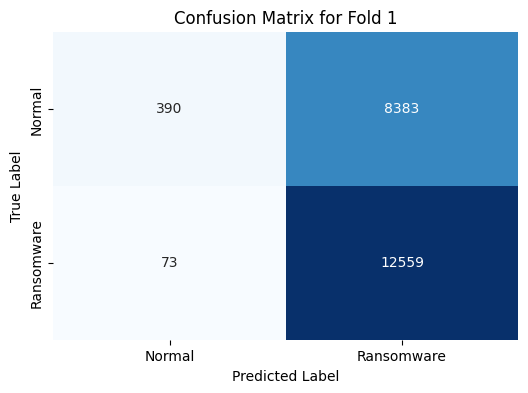

Fold 2
Accuracy for fold 2: 82.49%
F1 Score for fold 2: 0.8262
Precision for fold 2: 0.8332
Recall for fold 2: 0.8249
              precision    recall  f1-score   support

      Normal       0.75      0.86      0.80      8703
  Ransomware       0.89      0.80      0.84     12702

    accuracy                           0.82     21405
   macro avg       0.82      0.83      0.82     21405
weighted avg       0.83      0.82      0.83     21405



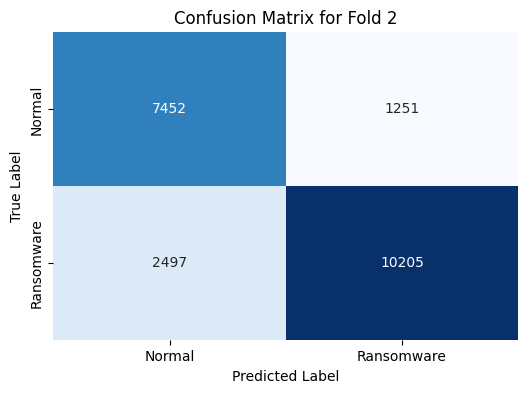

Fold 3
Accuracy for fold 3: 73.83%
F1 Score for fold 3: 0.7364
Precision for fold 3: 0.8101
Recall for fold 3: 0.7383
              precision    recall  f1-score   support

      Normal       0.62      0.95      0.75      8700
  Ransomware       0.94      0.59      0.73     12704

    accuracy                           0.74     21404
   macro avg       0.78      0.77      0.74     21404
weighted avg       0.81      0.74      0.74     21404



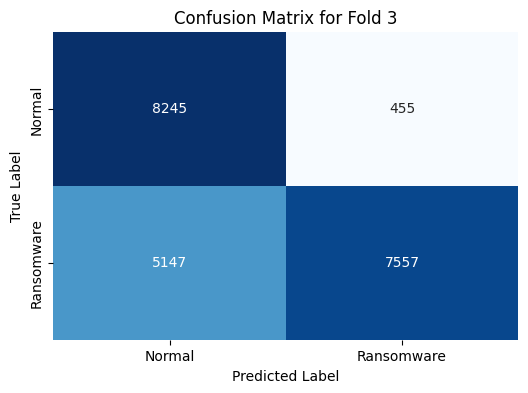

Fold 4
Accuracy for fold 4: 78.90%
F1 Score for fold 4: 0.7902
Precision for fold 4: 0.8246
Recall for fold 4: 0.7890
              precision    recall  f1-score   support

      Normal       0.68      0.92      0.78      8724
  Ransomware       0.93      0.70      0.80     12680

    accuracy                           0.79     21404
   macro avg       0.80      0.81      0.79     21404
weighted avg       0.82      0.79      0.79     21404



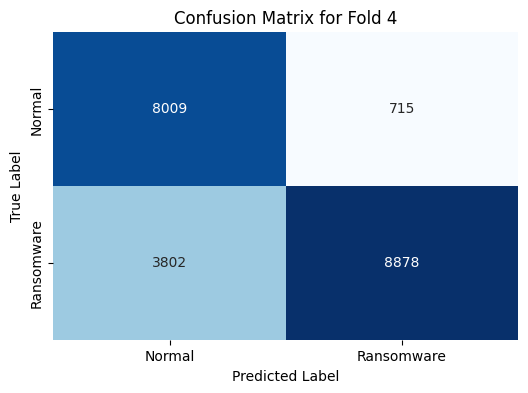

Fold 5


In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=50)
all_accuracy, all_f1_scores = [], []
conf_matrix_list = []
average_train_losses = []
average_val_accuracies = []
average_precisions = []
average_recalls = []
average_f1_scores = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'Fold {fold + 1}')

    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_fold, dtype=torch.long).to(device)
    X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val_fold, dtype=torch.long).to(device)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    model = GPTModel(input_dim=X_train_fold.shape[1], num_classes=2).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_accuracy = 0

    num_epochs = 50
    train_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for inputs, labels in train_loader:
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        with torch.no_grad():
            y_pred_probs = model(X_val_tensor)
            _, y_pred = torch.max(y_pred_probs, 1)

        accuracy = accuracy_score(y_val_fold, y_pred.cpu().numpy())
        f1 = f1_score(y_val_fold, y_pred.cpu().numpy(), average='weighted', zero_division=0)
        precision = precision_score(y_val_fold, y_pred.cpu().numpy(), average='weighted', zero_division=0)
        recall = recall_score(y_val_fold, y_pred.cpu().numpy(), average='weighted', zero_division=0)

        val_accuracies.append(accuracy)
        val_precisions.append(precision)
        val_recalls.append(recall)
        val_f1_scores.append(f1)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), f'model_best_fold_{fold + 1}.pt')

    conf_matrix = confusion_matrix(y_val_fold, y_pred.cpu().numpy())
    conf_matrix_list.append(conf_matrix)
    all_accuracy.append(accuracy)
    all_f1_scores.append(f1)

    print(f'Accuracy for fold {fold + 1}: {accuracy * 100:.2f}%')
    print(f'F1 Score for fold {fold + 1}: {f1:.4f}')
    print(f'Precision for fold {fold + 1}: {precision:.4f}')
    print(f'Recall for fold {fold + 1}: {recall:.4f}')
    cls_report = classification_report(y_val_fold, y_pred.cpu().numpy(), target_names=["Normal", "Ransomware"])
    print(cls_report)

    average_train_losses.append(train_losses)
    average_val_accuracies.append(val_accuracies)
    average_precisions.append(val_precisions)
    average_recalls.append(val_recalls)
    average_f1_scores.append(val_f1_scores)

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
                xticklabels=["Normal", "Ransomware"], yticklabels=["Normal", "Ransomware"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for Fold {fold + 1}')
    plt.show()

print(f'Average Accuracy: {np.mean(all_accuracy) * 100:.2f}%')
print(f'Average F1 Score: {np.mean(all_f1_scores):.4f}')

average_conf_matrix = np.mean(conf_matrix_list, axis=0)

plt.figure(figsize=(8, 6))
sns.heatmap(average_conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
            xticklabels=["Normal", "Ransomware"], yticklabels=["Normal", "Ransomware"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Average Confusion Matrix Across Folds')
plt.show()

print("Hasil Deteksi Pola Enkripsi Ransomware:")
for i, (acc, f1) in enumerate(zip(all_accuracy, all_f1_scores)):
    print(f'Fold {i + 1}: Akurasi = {acc * 100:.2f}%, F1 Score = {f1:.4f}')

In [ ]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
for fold in range(len(average_train_losses)):
    plt.plot(average_train_losses[fold], label=f'Fold {fold + 1}')
plt.title('Training Loss across 10 Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(title="Folds")
plt.grid()

plt.subplot(2, 3, 2)
for fold in range(len(average_val_accuracies)):
    plt.plot(average_val_accuracies[fold], label=f'Fold {fold + 1}')
plt.title('Validation Accuracy across 10 Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(title="Folds")
plt.grid()

plt.subplot(2, 3, 3)
for fold in range(len(average_precisions)):
    plt.plot(average_precisions[fold], label=f'Fold {fold + 1}')
plt.title('Validation Precision across 10 Folds')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(title="Folds")
plt.grid()

plt.subplot(2, 3, 4)
for fold in range(len(average_recalls)):
    plt.plot(average_recalls[fold], label=f'Fold {fold + 1}')
plt.title('Validation Recall across 10 Folds')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend(title="Folds")
plt.grid()

plt.subplot(2, 3, 5)
for fold in range(len(average_f1_scores)):
    plt.plot(average_f1_scores[fold], label=f'Fold {fold + 1}')
plt.title('Validation F1 Score across 10 Folds')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend(title="Folds")
plt.grid()

plt.tight_layout()
plt.show()

## Parameter Tuning

In [ ]:
from itertools import product
# Parameter grid
param_grid = {
    'lr': [0.001, 0.0005],
    'batch_size': [16, 32],
    'nhead': [2, 4]
}

best_accuracy = 0
best_params = None

for lr, batch_size, nhead in product(param_grid['lr'], param_grid['batch_size'], param_grid['nhead']):
    print(f'Training with lr={lr}, batch_size={batch_size}, nhead={nhead}')

    # Instantiate model (assuming GPTModel class is defined)
    model = GPTModel(input_dim=X_train_fold.shape[1], num_classes=2, nhead=nhead).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    for epoch in range(5):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred_probs = model(X_val_tensor)
        _, y_pred = torch.max(y_pred_probs, 1)
        accuracy = accuracy_score(y_val_fold, y_pred.cpu().numpy())

    print(f'Validation Accuracy: {accuracy * 100:.2f}%')

    # Update best accuracy and parameters
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'lr': lr, 'batch_size': batch_size, 'nhead': nhead}

print(f'Best Params: {best_params} with Accuracy: {best_accuracy * 100:.2f}%')
best_lr = best_params["lr"]
best_batch_size = best_params["batch_size"]
best_nhead = best_params["nhead"]

## With Best Param

In [ ]:
class_names = ["Normal", "Ransomware"]

kf = KFold(n_splits=10, shuffle=True, random_state=50)
all_accuracy, all_f1_scores = [], []
conf_matrix_list = []
average_train_losses = []
average_val_accuracies = []
average_precisions = []
average_recalls = []
average_f1_scores = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'Fold {fold + 1}')

    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_fold, dtype=torch.long).to(device)
    X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val_fold, dtype=torch.long).to(device)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)

    model = GPTModel(input_dim=X_train_fold.shape[1], num_classes=len(class_names)).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

    best_accuracy = 0

    num_epochs = 50
    train_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        with torch.no_grad():
            y_pred_probs = model(X_val_tensor)
            _, y_pred = torch.max(y_pred_probs, 1)

        accuracy = accuracy_score(y_val_fold, y_pred.cpu().numpy())
        f1 = f1_score(y_val_fold, y_pred.cpu().numpy(), average='weighted', zero_division=0)
        precision = precision_score(y_val_fold, y_pred.cpu().numpy(), average='weighted', zero_division=0)
        recall = recall_score(y_val_fold, y_pred.cpu().numpy(), average='weighted', zero_division=0)

        val_accuracies.append(accuracy)
        val_precisions.append(precision)
        val_recalls.append(recall)
        val_f1_scores.append(f1)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), f'model_best_fold_{fold + 1}.pt')

    conf_matrix = confusion_matrix(y_val_fold, y_pred.cpu().numpy())
    conf_matrix_list.append(conf_matrix)
    all_accuracy.append(accuracy)
    all_f1_scores.append(f1)

    print(f'Accuracy for fold {fold + 1}: {accuracy * 100:.2f}%')
    print(f'F1 Score for fold {fold + 1}: {f1:.4f}')
    print(f'Precision for fold {fold + 1}: {precision:.4f}')
    print(f'Recall for fold {fold + 1}: {recall:.4f}')
    cls_report = classification_report(y_val_fold, y_pred.cpu().numpy(), target_names=["Normal", "Ransomware"])
    print(cls_report)

    average_train_losses.append(train_losses)
    average_val_accuracies.append(val_accuracies)
    average_precisions.append(val_precisions)
    average_recalls.append(val_recalls)
    average_f1_scores.append(val_f1_scores)

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
                xticklabels=["Normal", "Ransomware"], yticklabels=["Normal", "Ransomware"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for Fold {fold + 1}')
    plt.show()

print(f'Average Accuracy: {np.mean(all_accuracy) * 100:.2f}%')
print(f'Average F1 Score: {np.mean(all_f1_scores):.4f}')

average_conf_matrix = np.mean(conf_matrix_list, axis=0)

plt.figure(figsize=(8, 6))
sns.heatmap(average_conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Average Confusion Matrix Across Folds')
plt.show()

print("Hasil Deteksi Pola Enkripsi Ransomware:")
for i, (acc, f1) in enumerate(zip(all_accuracy, all_f1_scores)):
    print(f'Fold {i + 1}: Akurasi = {acc * 100:.2f}%, F1 Score = {f1:.4f}')

In [ ]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
for fold in range(len(average_train_losses)):
    plt.plot(average_train_losses[fold], label=f'Fold {fold + 1}')
plt.title('Training Loss across 10 Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(title="Folds")
plt.grid()

plt.subplot(2, 3, 2)
for fold in range(len(average_val_accuracies)):
    plt.plot(average_val_accuracies[fold], label=f'Fold {fold + 1}')
plt.title('Validation Accuracy across 10 Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(title="Folds")
plt.grid()

plt.subplot(2, 3, 3)
for fold in range(len(average_precisions)):
    plt.plot(average_precisions[fold], label=f'Fold {fold + 1}')
plt.title('Validation Precision across 10 Folds')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(title="Folds")
plt.grid()

plt.subplot(2, 3, 4)
for fold in range(len(average_recalls)):
    plt.plot(average_recalls[fold], label=f'Fold {fold + 1}')
plt.title('Validation Recall across 10 Folds')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend(title="Folds")
plt.grid()

plt.subplot(2, 3, 5)
for fold in range(len(average_f1_scores)):
    plt.plot(average_f1_scores[fold], label=f'Fold {fold + 1}')
plt.title('Validation F1 Score across 10 Folds')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend(title="Folds")
plt.grid()

plt.tight_layout()
plt.show()

## with class balancing using smote

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balance, y_train_balance = smote.fit_resample(X_train_df, y_train_df)

X_train_balance, X_test_balance, y_train_balance, y_test_balance = train_test_split(X_train_balance, y_train_balance, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_balance = scaler.fit_transform(X_train_balance)
X_test_balance = scaler.transform(X_test_balance)

In [ ]:
class_names = ["Normal", "Ransomware"]

kf = KFold(n_splits=10, shuffle=True, random_state=50)
all_accuracy, all_f1_scores = [], []
conf_matrix_list = []
average_train_losses = []
average_val_accuracies = []
average_precisions = []
average_recalls = []
average_f1_scores = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold, (train_index, val_index) in enumerate(kf.split(X_train_balance)):
    print(f'Fold {fold + 1}')

    X_train_fold, X_val_fold = X_train_balance[train_index], X_train_balance[val_index]
    y_train_fold, y_val_fold = y_train_balance[train_index], y_train_balance[val_index]

    X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_fold, dtype=torch.long).to(device)
    X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val_fold, dtype=torch.long).to(device)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)

    model = GPTModel(input_dim=X_train_fold.shape[1], num_classes=len(class_names)).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

    best_accuracy = 0

    num_epochs = 50
    train_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        with torch.no_grad():
            y_pred_probs = model(X_val_tensor)
            _, y_pred = torch.max(y_pred_probs, 1)

        accuracy = accuracy_score(y_val_fold, y_pred.cpu().numpy())
        f1 = f1_score(y_val_fold, y_pred.cpu().numpy(), average='weighted', zero_division=0)
        precision = precision_score(y_val_fold, y_pred.cpu().numpy(), average='weighted', zero_division=0)
        recall = recall_score(y_val_fold, y_pred.cpu().numpy(), average='weighted', zero_division=0)

        val_accuracies.append(accuracy)
        val_precisions.append(precision)
        val_recalls.append(recall)
        val_f1_scores.append(f1)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), f'model_best_fold_{fold + 1}.pt')

    conf_matrix = confusion_matrix(y_val_fold, y_pred.cpu().numpy())
    conf_matrix_list.append(conf_matrix)
    all_accuracy.append(accuracy)
    all_f1_scores.append(f1)

    print(f'Accuracy for fold {fold + 1}: {accuracy * 100:.2f}%')
    print(f'F1 Score for fold {fold + 1}: {f1:.4f}')
    print(f'Precision for fold {fold + 1}: {precision:.4f}')
    print(f'Recall for fold {fold + 1}: {recall:.4f}')
    cls_report = classification_report(y_val_fold, y_pred.cpu().numpy(), target_names=["Normal", "Ransomware"])
    print(cls_report)

    average_train_losses.append(train_losses)
    average_val_accuracies.append(val_accuracies)
    average_precisions.append(val_precisions)
    average_recalls.append(val_recalls)
    average_f1_scores.append(val_f1_scores)

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
                xticklabels=["Normal", "Ransomware"], yticklabels=["Normal", "Ransomware"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for Fold {fold + 1}')
    plt.show()

print(f'Average Accuracy: {np.mean(all_accuracy) * 100:.2f}%')
print(f'Average F1 Score: {np.mean(all_f1_scores):.4f}')

average_conf_matrix = np.mean(conf_matrix_list, axis=0)

plt.figure(figsize=(8, 6))
sns.heatmap(average_conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Average Confusion Matrix Across Folds')
plt.show()

print("Hasil Deteksi Pola Enkripsi Ransomware:")
for i, (acc, f1) in enumerate(zip(all_accuracy, all_f1_scores)):
    print(f'Fold {i + 1}: Akurasi = {acc * 100:.2f}%, F1 Score = {f1:.4f}')

In [ ]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
for fold in range(len(average_train_losses)):
    plt.plot(average_train_losses[fold], label=f'Fold {fold + 1}')
plt.title('Training Loss across 10 Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(title="Folds")
plt.grid()

plt.subplot(2, 3, 2)
for fold in range(len(average_val_accuracies)):
    plt.plot(average_val_accuracies[fold], label=f'Fold {fold + 1}')
plt.title('Validation Accuracy across 10 Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(title="Folds")
plt.grid()

plt.subplot(2, 3, 3)
for fold in range(len(average_precisions)):
    plt.plot(average_precisions[fold], label=f'Fold {fold + 1}')
plt.title('Validation Precision across 10 Folds')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(title="Folds")
plt.grid()

plt.subplot(2, 3, 4)
for fold in range(len(average_recalls)):
    plt.plot(average_recalls[fold], label=f'Fold {fold + 1}')
plt.title('Validation Recall across 10 Folds')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend(title="Folds")
plt.grid()

plt.subplot(2, 3, 5)
for fold in range(len(average_f1_scores)):
    plt.plot(average_f1_scores[fold], label=f'Fold {fold + 1}')
plt.title('Validation F1 Score across 10 Folds')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend(title="Folds")
plt.grid()

plt.tight_layout()
plt.show()